In [121]:
from utils import *
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import warnings 

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
mp_genome_ids = ['mp_15', 'mp_1', 'mp_5', 'mp_12', 'mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20'] # From sandbox-1.ipynb
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in pd.read_csv('ref_genes.csv', comment='#').groupby('genome_id')}

In [161]:
# First question to address is which genes are the most highly expressed in each strain and sample?
metat_df = metat_load(data_dir='../data/metat/').rename(columns={'length':'genome_size'})
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)

agg_funcs = {'read_count':'sum', 'genome_size':'sum', 'library_size':'first', 'year':'first', 'location':'first', 'reactor':'first', 'detected':'mean'}
metat_agg_df = metat_df.groupby(['genome_id', 'sample_id']).agg(agg_funcs).reset_index()
metat_agg_df['rpkm'] = metat_agg_df.read_count / (metat_agg_df.genome_size / 1e3) / (metat_agg_df.library_size / 1e6)
metat_agg_df['sample_id'] = metat_agg_df.sample_id.str.replace('_metat', '')

In [164]:
metat_agg_df[metat_agg_df.genome_id == 'mp_18']

,genome_id,sample_id,read_count,genome_size,library_size,year,location,reactor,detected,rpkm
210,mp_18,ck_bottom_2024,10431,2242654,286635956,2024,bottom,ck,0.427191,0.016227
211,mp_18,ck_bottom_2025,32916,2242654,273454876,2025,bottom,ck,0.435778,0.053673
212,mp_18,ck_middle_2025,36418,2242654,250326764,2025,middle,ck,0.326655,0.064870
213,mp_18,ck_top_2025,12293,2242654,274392272,2025,top,ck,0.130948,0.019977
214,mp_18,n_bottom_2024,818,2242654,177712338,2024,bottom,n,0.119141,0.002052
215,mp_18,n_bottom_2025,3313,2242654,295624030,2025,bottom,n,0.088014,0.004997
216,mp_18,n_middle_2024,1535,2242654,334480934,2024,middle,n,0.134884,0.002046
217,mp_18,n_middle_2025,27896,2242654,294446328,2025,middle,n,0.244723,0.042245
218,mp_18,n_top_2024,16524,2242654,303075226,2024,top,n,0.508766,0.024311
219,mp_18,n_top_2025,8875,2242654,229018512,2025,top,n,0.115564,0.017280


In [ ]:
# sns.scatterplot(figure_df, x='log10_rpkm_2024', y='log10_rpkm_2025', color='gray', ax=ax_b, hue='invalid', palette='Grays', legend=False)
# ax_b.set_ylabel('$log_{10}(RPKM_{2025})$')
# ax_b.set_xlabel('$log_{10}(RPKM_{2024})$')
# # ax_b.set_ylim(ymin=0, ymax=20)
# # ax_b.set_xlim(xmin=0, xmax=20)

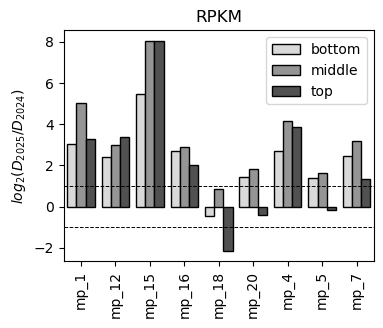

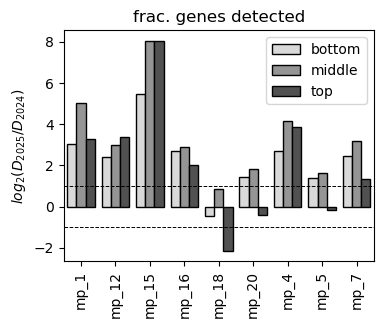

In [ ]:
# Because of the compositional nature of the data, it is hard to distinguish between true zeros and sampling zeros, particularly
# in lowly-expressed genes. 

metric = 'RPKM'
metric = 'D'

def plot_fold_change(figure_df:pd.DataFrame, metric=metric, title='activity'):

    fig, ax = plt.subplots(figsize=(4, 3)) 

    figure_df = figure_df[(figure_df.reactor == 'n') & figure_df.genome_id.isin(mp_genome_ids)].copy()
    figure_df = figure_df.rename(columns={'rpkm':'RPKM', 'detected':'D'})
    figure_df = figure_df.pivot(index=['genome_id', 'location'], values=metric, columns='year')
    figure_df = figure_df.reset_index()
    figure_df[f'log2_{metric}_ratio'] = np.log2(figure_df['2025'] / figure_df['2024'])
    figure_df[f'log10_{metric}_2024'] = np.log10(figure_df['2024'])
    figure_df[f'log10_{metric}_2025'] = np.log10(figure_df['2025'])

    sns.barplot(figure_df, y=f'log2_{metric}_ratio', x='genome_id', hue='location', palette='Grays', ax=ax, edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('$log_2(' + metric + '_{2025} / ' + metric + '_{2024})$')
    ax.set_xlabel('')
    ax.get_legend().set_title('')
    ax.axhline(1, ls='--', color='black', lw=0.7)
    ax.axhline(-1, ls='--', color='black', lw=0.7)
    ax.set_title(title)
    plt.show()

plot_fold_change(metat_agg_df, title='RPKM')
plot_fold_change(metat_agg_df, metric='D', title='frac. genes detected')

# Focusing on mp_18: With filtering approaches (1) and (2), many housekeeping genes (e.g. Rbp11, Rbp2) seem to be up-regulated 
# substantially (top 5th percentile), which indicates to me that the CLR assumption may not hold (geometric mean is either too low in 
# 2025 or too high in 2024). This could be biological, if overall baseline expression is higher in 2025. This is supported by the observation that,
# even though RPKM increases, the fraction of the genome detected decreases. Conclusion is that CLR normalization will not work for mp_18. 



get_diff: Retained 200 genes for mp_18.
get_diff: Retained 53 genes for mp_18.


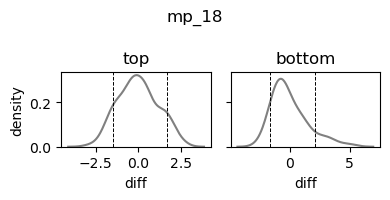

In [152]:
def get_diff(metat_df, location:str='bottom', reactor:str='n', genome_id=None):

    mask = ((metat_df.genome_id == genome_id) & (metat_df.reactor == reactor) & (metat_df.location == location))
    metat_df = metat_df[mask].copy()

    # metat_df = pd.concat([metat_filter(metat_df, threshold=20, min_samples=1), metat_filter(metat_df, threshold=1, min_samples=2)])
    metat_df = metat_filter(metat_df, threshold=1, min_samples=2)
    # metat_df = metat_filter(metat_df, threshold=min_rpkm, min_samples=1)
    metat_df = metat_df.drop_duplicates(['gene_id', 'year'])
    print(f'get_diff: Retained {metat_df.gene_id.nunique()} genes for {genome_id}.')
    metat_df = metat_normalize(metat_df, method='clr')

    diff_df = dict()
    diff_df = {year:df.set_index('gene_id').sort_index() for year, df in metat_df.groupby('year')}

    diff_df = diff_df['2025'][['read_count_normalized_clr']] - diff_df['2024'][['read_count_normalized_clr']]
    diff_df = diff_df.reset_index().rename(columns={'read_count_normalized_clr':'diff'})
    diff_df['genome_id'] = genome_id
    diff_df['location'] = location
    return diff_df

genome_id = 'mp_18'
quantile = 0.1
locations = ['top', 'bottom']

fig, axes = plt.subplots(figsize=(2 * len(locations), 2), ncols=len(locations), sharey=True)

df = list()

for ax, location in zip(axes, locations):
    figure_df = get_diff(metat_df, genome_id=genome_id, location=location)
    up_threshold = np.quantile(figure_df['diff'].values, 1 - quantile).item()
    down_threshold = np.quantile(figure_df['diff'].values, quantile).item()

    sns.kdeplot(figure_df, x='diff', common_norm=False, color='gray', ax=ax)
    ax.axvline(up_threshold, ls='--', color='black', lw=0.7)
    ax.axvline(down_threshold, ls='--', color='black', lw=0.7)
    # ax.axvline(mean, ls='-', color='black', lw=1)
    ax.set_ylabel('density')
    ax.set_title(location)
    
    df.append(figure_df[(figure_df['diff'] > up_threshold)].assign(regulation='up').copy())
    df.append(figure_df[(figure_df['diff'] < down_threshold)].assign(regulation='down').copy())

df = pd.concat(df)

fig.suptitle(genome_id)
fig.tight_layout()
plt.show()

In [ ]:
for gene_id, df_ in df[df.regulation == 'up'].merge(interproscan_df, on='gene_id', how='left').groupby('gene_id'):
    for row in df_[df_.interpro_accession != '-'].drop_duplicates(['interpro_accession', 'location']).itertuples():
        print(row.location, row.interpro_accession, row.interpro_description)
    print()

# Two filtering approaches:
# (1) threshold=1, min_samples=1, Results in a unimodal distribution of differential expression values centered around 0, which indicates that
#   for the majority of genes detected in both samples, the difference in relative expression is negligible.
# (2) threshold~10, min_samples=1





top nan nan

top IPR016024 Armadillo-type fold
top IPR011989 Armadillo-like helical

top IPR013784 Carbohydrate-binding-like fold
top IPR054470 FIMAH domain

top IPR004680 Citrate transporter-like domain
top IPR000802 Arsenical pump membrane protein, ArsB

top IPR036603 RNA polymerase, RBP11-like subunit
top IPR036643 DNA-directed RNA polymerase, insert domain superfamily
top IPR011263 DNA-directed RNA polymerase, RpoA/D/Rpb3-type
top IPR050518 Archaeal Rpo3/Eukaryotic RPB3 RNA Polymerase Subunit
top IPR011262 DNA-directed RNA polymerase, insert domain

top IPR015712 DNA-directed RNA polymerase, subunit 2
top IPR019969 DNA-directed RNA polymerase subunit Rpo2
top IPR037033 DNA-directed RNA polymerase, subunit 2, hybrid-binding domain superfamily
top IPR014724 RNA polymerase Rpb2, OB-fold
top IPR007120 DNA-directed RNA polymerase, subunit 2, hybrid-binding domain
top IPR007641 RNA polymerase Rpb2, domain 7
top IPR007646 RNA polymerase Rpb2, domain 4

top IPR017185 Uncharacterised conser

In [126]:
# Want to plot the distribution of normalized ALR values... 

# fig, ax = plt.subplots(figsize=(5, 5))
# sample_id = 'n_bottom_2025_metat'
# figure_df = metat_df[metat_df.sample_id == sample_id].copy()
# sns.kdeplot(figure_df, hue='genome_id', x='read_count_normalized_clr', common_norm=False, palette='Grays')
# ax.set_title(sample_id)

In [127]:
# First want to look at the metabolic potential of the genomes. What genes are present?
# Relevant metabolism things: (https://www.cell.com/trends/microbiology/fulltext/S0966-842X(25)00031-9)
# (1) Iron reduction (https://pmc.ncbi.nlm.nih.gov/articles/PMC7005843/)
# (2) Nitrate reduction
# (3) Humic acid reduction 
# (4) Methanotrophy 
# Denitrification (nitrate to nitrite) https://www.kegg.jp/module/M00529
# Might also be worth looking into genes for stress response. 



In [ ]:

# Using the abundance data... In cases where RPKM is reasonably-high across years, it seems reasonable to assume that any zeros
# are true zeros, not sampling zeros. 
# print('Num. comparisons:', len(figure_df))
# min_rpkm = 10
# print(f'Num. comparisons with both RPKM > {min_rpkm}:', ((figure_df['2025'] > min_rpkm) & (figure_df['2024'] > min_rpkm)).sum())
# print()
# for row in figure_df[(figure_df['2025'] > min_rpkm) & (figure_df['2024'] > min_rpkm)].itertuples():
#     print(row.genome_id, row.location)

In [128]:
processes = dict()
processes['methanotrophy'] = ['methyl+coenzyme', 'coM+methyltransferase', 'coenzyme+F430+synthase', 'methyl+coenzyme+M+reductase']
processes['nitrate_reduction'] = ['narG', 'narH', 'nari', 'narK', 'narJ'] 
processes['iron_reduction_pilus'] = ['archaeal+pilin']
processes['iron_reduction_omc'] = ['omcA', 'omcC', 'omcB', 'omcE', 'omcF', 'mtrA', 'mtrB', 'mtrC']

In [129]:

database_patterns = dict()
database_patterns[r'PF\d+'] = 'pfam'
database_patterns[r'PTHR\d+'] = 'panther'
database_patterns[r'NF\d+'] = 'ncbifam'
database_patterns[r'IPR\d+'] = 'interpro'
database_patterns[r'PIRSF\d+'] = 'pirsf'
database_patterns[r'TIGR\d+'] = 'ncbifam'
database_patterns[r'cd\d+'] = 'cdd'
database_patterns[r'PS\d+'] = 'prosite'
database_patterns[r'G[\d\.]+'] = 'gene3d'
database_patterns[r'SSF\d+'] = 'ssf'
database_patterns[r'SFLD\d+'] = 'sfld'

def _interpro_get_metadata(accession:str):

    database = None
    for database_pattern, database in database_patterns.items():
        if re.match(database_pattern, accession) is not None:
            break

    info = dict()
    info['accession'] = accession
    info['database'] = database
    
    try:
        url = f'https://www.ebi.ac.uk/interpro/api/entry/{database}/{accession}'
        result = requests.get(url).text 
        result = json.loads(result)['metadata']
        info['name'] = result['name']['name']
        info['short_name'] = result['name']['short']
        info['description'] = result['description']['text']
        info['database'] = database
    except:
        pass 
    return info

def interpro_get_metadata(process, queries, n_hits:int=20):
    accessions = list()
    url = 'https://www.ebi.ac.uk/ebisearch/ws/rest/interpro?query={query}&size={n_hits}' # Reliability kind of drops off after the first 20 or so queries.
    for query in queries:
        result = requests.get(url.format(query=query, n_hits=n_hits)).text
        accessions += re.findall(r'id="([a-zA-Z0-9\.]+)"', result)
    accessions = np.unique(accessions) # Make sure there are no duplicates. 
    print(f'Obtained {len(accessions)} accessions for {process}')

    interpro_metadata_df = list()
    for accession in tqdm(accessions, desc='Collecting InterPro metadata.'):
        info = _interpro_get_metadata(accession)
        interpro_metadata_df.append(info)
    interpro_metadata_df = pd.DataFrame(interpro_metadata_df)
    interpro_metadata_df = interpro_metadata_df.drop_duplicates('accession')
    interpro_metadata_df.to_csv(f'../data/interpro_{process}.csv')

# for process, queries in processes.items():
#     interpro_get_metadata(process, queries)
# interpro_get_metadata('iron_reduction_pilus', processes['iron_reduction_pilus'])
# interpro_get_metadata('methanotrophy', processes['methanotrophy'])

genes = dict()
for process in processes:
    accessions = pd.read_csv(f'../data/interpro_{process}.csv', usecols=['accession']).accession.values 
    mask = interproscan_df.signature_accession.isin(accessions)
    genes[process] = interproscan_df[mask].gene_id.unique()

accessions = ['G3DSA:1.20.840.10']
interproscan_df = interproscan_df.sort_values('e_value') # Both alpha and beta subunits are covered by this annotation, only want to get the best hit (subunit A, I think)
mask = interproscan_df.signature_accession.isin(accessions) & ~interproscan_df.duplicated(['genome_id', 'signature_accession'], keep='first')
genes['methanotrophy_mcra'] = interproscan_df[mask].gene_id


KeyError: Index(['genome_id'], dtype='object')

In [ ]:
genes['methanotrophy_mcra']

9372     mp_16.1_1450
15397     mp_13.287_4
7624      mp_15.19_59
91        mp_4.1_1090
11445      mp_1.5_196
13256    mp_20.1_1980
1945     mp_18.1_2150
Name: gene_id, dtype: object

In [ ]:
# Want to take a closer look at which Methanoperedens genes are expressed generally, in each reactor, to get a sense of the metabolism in each reactor. 
# If I'm not doing differential expression analysis, I don't think I need to filter out low read counts. 
metat_df = metat_load()
metat_df = metat_df[metat_df.genome_id.isin(mp_genome_ids)].copy()
metat_df['sample_id'] = metat_df.sample_id.str.replace('_metat', '')
metat_df = metat_df.merge(interproscan_df.sort_values('e_value').drop_duplicates(['genome_id', 'gene_id']), on=['genome_id', 'gene_id'], how='left')
# metat_df = pd.concat([metat_filter(df, threshold=1, min_samples=1, field='read_count') for _, df in metat_df.groupby('genome_id', group_keys=True)])

ref_genes = {genome_id:[] for genome_id in mp_genome_ids}
for gene in genes['methanotrophy']:
    ref_genes[gene.split('.')[0]].append(gene)

# metat_df =  metat_normalize(metat_df, ref_genes=ref_genes)
# metat_df['read_count'] = metat_df.read_count + 1
# metat_df['rpkm'] = metat_df.read_count / (metat_df.length / 1e3) / (metat_df.library_size / 1e6)


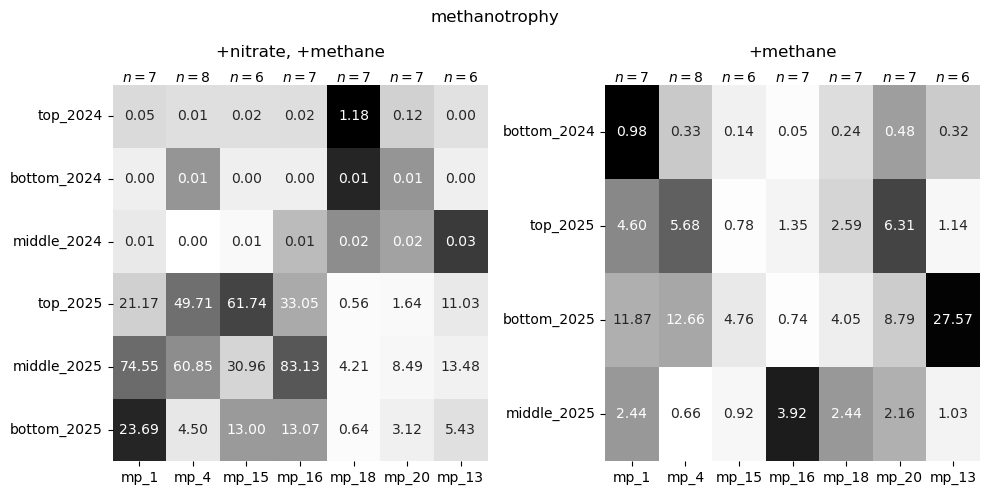

In [ ]:
# Heatmap figure with strain on the x-axis and sample on the y-axis. One figure for each type of metabolism, 
# and each square is the proportion of genes related to that metabolism expressed in that particular sample
def figure(metat_df:pd.DataFrame, genes=None, title:str='', cpm:bool=False, genome_ids=mp_genome_ids):
    
    fig, (n_ax, ck_ax) = plt.subplots(figsize=(10, 5), ncols=2)

    metat_df = metat_df.copy()
    metat_df = metat_df[metat_df.genome_id.isin(genome_ids)].copy()
    metat_df['location'] = pd.Categorical(metat_df.location, categories=['bottom', 'middle', 'top'])
    metat_df['genome_id'] = pd.Categorical(metat_df.genome_id, categories=genome_ids)
    metat_df = metat_df.sort_values(['year', 'genome_id'])
    metat_df = metat_df[metat_df.gene_id.isin(genes)].copy()

    if cpm:
        metat_df['read_count'] = metat_df.read_count / (metat_df.library_size / 1e6) # Per million reads.
    fmt = '.2f' if cpm else 'd'

    for (reactor, df) in metat_df.groupby('reactor'): 
        ax = n_ax if (reactor == 'n') else ck_ax
        df['sample_id'] = df.sample_id.str.replace(f'{reactor}_', '')
        sample_ids = df.sample_id.unique()
        figure_df = pd.DataFrame(index=sample_ids, columns=genome_ids)

        totals = list()
        for genome_id, df_ in df.groupby('genome_id', observed=True):
            totals.append(df_.gene_id.nunique()) # Total number of genes present associated with the metabolism. 
            figure_df[genome_id] = df_[df_.read_count > 0].groupby('sample_id').size()
            figure_df[genome_id] = df_[df_.read_count > 0].groupby('sample_id').read_count.mean() 
            # get_gmean = lambda df : gmean(df.read_count.values)
            # figure_df[genome_id] = df[df.read_count_original > 0].groupby('sample_id').read_count_normalized_clr.max() 

        # figure_df = figure_df.sort_index().apply(pd.to_numeric, errors='coerce').fillna(0)# .astype(int)
        figure_df = figure_df.apply(pd.to_numeric, errors='coerce').fillna(0)# .astype(int)
        sns.heatmap((figure_df - figure_df.mean(axis=1).values[:, None]) / figure_df.std(axis=1).values[:, None], cmap='Grays', annot=figure_df, cbar=False, fmt=fmt, ax=ax)
        
        for x, n in zip(ax.get_xticks(), totals):
            ax.text(x, ax.get_ylim()[-1], '$n=$' + str(n), va='bottom', ha='center')
        ax.set_title('+nitrate, +methane' if (reactor == 'n') else '+methane', pad=20)
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
        
    fig.suptitle(title)
    fig.tight_layout()

    return figure_df

mp_genome_ids = ['mp_1', 'mp_4', 'mp_15', 'mp_16', 'mp_18', 'mp_20', 'mp_13']

# figure_df = figure(metat_df, genes=genes['iron_reduction_pilus'], title='iron reduction pilus', cpm=True)
# figure_df = figure(metat_df, genes=genes['nitrate_reduction'], title='nitrate reduction', cpm=True)
figure_df = figure(metat_df, genes=genes['methanotrophy'], title='methanotrophy', cpm=True, genome_ids=mp_genome_ids)
# The methanotrophy gene with crazy high expression in mp_2 is methyl-coenzyme reductase


In [ ]:
# Maybe the best way to think about expression is just as a presence or absence matrix, perhaps with a score corresponding to 
# the number of samples the gene is detected in. Probably should look at the ck and n reactors separately, not sure yet about
# 2024 versus 2025 in the n reactor, considering there are obvious metabolic changes.

id_cols = ['gene_id', 'genome_id']
df = metat_df.drop_duplicates(id_cols)[id_cols].copy()
# Maks sure to account for the pseudocount here, so make sure everything is > 1 not >= 1.
df = df.merge(metat_df.groupby(id_cols).apply(lambda df : ((df.reactor == 'ck') & (df.read_count > 1)).sum(), include_groups=False).reset_index(name='ck_sample_count'), on=id_cols)
df = df.merge(metat_df.groupby(id_cols).apply(lambda df : ((df.reactor == 'n') & (df.read_count > 1)).sum(), include_groups=False).reset_index(name='n_sample_count'), on=id_cols)
df['total'] = df.ck_sample_count + df.n_sample_count
df = df.sort_values('total')

interproscan_df = interproscan_df.drop_duplicates(['genome_id', 'gene_id']).rename(columns={'signature_description':'annotation'})
df = df.merge(interproscan_df[['genome_id', 'gene_id', 'annotation']], on=['genome_id', 'gene_id'], how='left')
df['annotation'] = df.annotation.fillna('-')
# df['annotation'] = [get_annotation(row.gene_id, row.genome_id) for row in tqdm(list(df.itertuples()), 'Collecting annotations from InterProScan data...')]

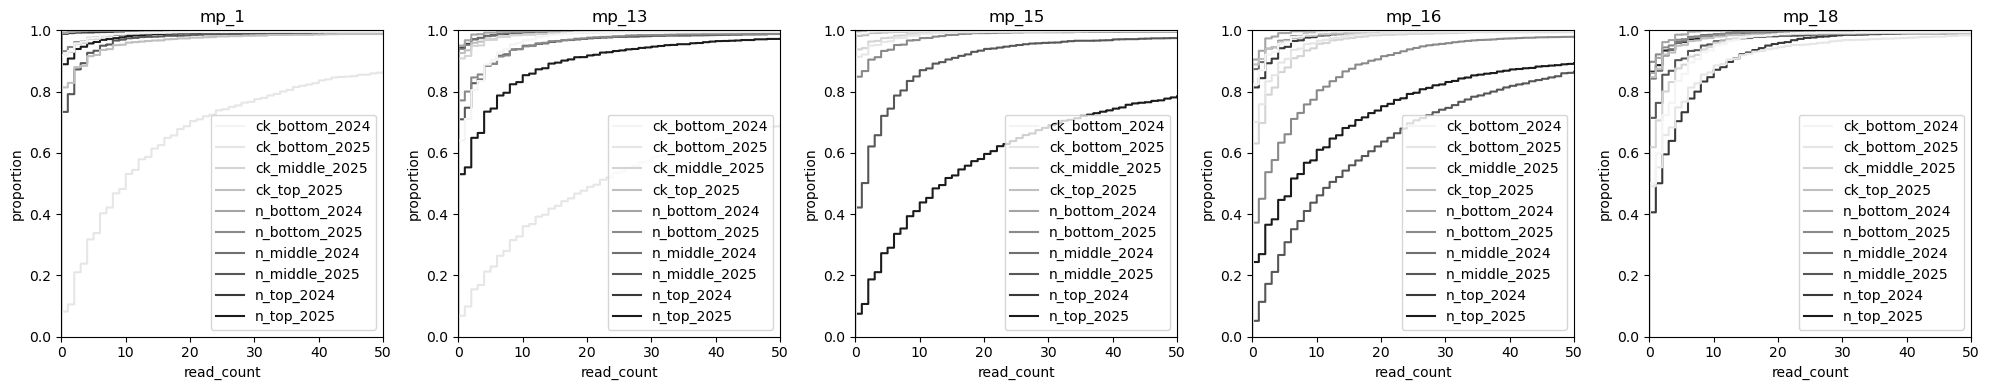

In [ ]:
# How best to normalize this data? Would be good to compare the relative expression levels across samples, so probably
# a good idea to use ALR normalization again, at least for Methanoperedens. Not sure what to do about the Borgs. 

def plot_read_counts(metat_df, ax=None, title:str='', legend:bool=True):
    figure_df = metat_df.sort_values('sample_id')
    figure_df = figure_df[figure_df.sample_id != 'n_bottom_2024_metat'].copy() # Sample with small library size.
    ax.set_title(title)
    sns.ecdfplot(figure_df, x='read_count', hue='sample_id', palette='Grays', ax=ax, legend=legend)
    ax.get_legend().set_title('')
    ax.set_xlim(xmin=0, xmax=50)
    ax.set_ylabel('proportion')

fig, axes = plt.subplots(figsize=(20, 4), ncols=5)

for ax, (genome_id, df) in zip(axes, list(metat_df[metat_df.genome_id.str.startswith('mp_')].groupby('genome_id'))):
    plot_read_counts(df, ax=ax, title=genome_id) #, legend=(genome_id == 'mp_5'))

fig.tight_layout()
plt.show()


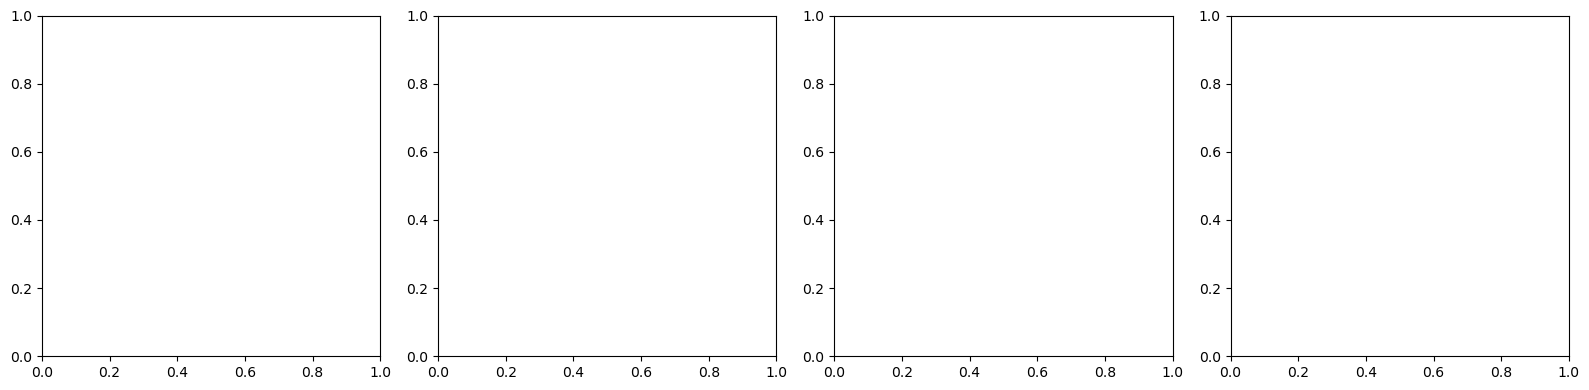

In [ ]:
# Also need to look at Borg expression to figure out how on earth to normalize it. 

fig, axes = plt.subplots(figsize=(16, 4), ncols=4)

genome_ids = ['black_borg', 'saturn_mini_borg_2', 'jupiter_mini_borg_3', 'linear_ece_19kb']
for ax, (genome_id, df) in zip(axes, list(metat_df[metat_df.genome_id.isin(genome_ids)].groupby('genome_id'))):
    plot_read_counts(df, ax=ax, title=genome_id) #, legend=(genome_id == 'mp_5'))

fig.tight_layout()
plt.show()


In [ ]:
# # Use HMMs from the FeGenie library to look for genes related to iron reduction. 
# hmmsearch_df = list()

# for path in glob.glob('../data/data/*.fa'):
#     genome_id = os.path.basename(path).replace('.fa', '')
#     output_path = f'../data/hmmsearch/{genome_id}-iron_reduction.tbl'
#     if not os.path.exists(output_path):
#         subprocess.run(f'hmmsearch --cpu 16 --tblout {output_path} ../data/hmms/iron_reduction.hmm {path} ', shell=True, check=True)
#     cols = ['query_id', 'query_description', 'target_id', 'target_decription', 'e_value', 'score', 'bias']
#     df = pd.read_csv(output_path, sep=r'\s+', comment='#', usecols=np.arange(len(cols)), names=cols)
#     if len(df) == 0:
#         continue
#     df['genome_id'] = genome_id
#     hmmsearch_df.append(df)

# hmmsearch_df = pd.concat(hmmsearch_df)
# hmmsearch_df = hmmsearch_df[is_mp(hmmsearch_df)].copy()
# hmmsearch_df = hmmsearch_df[hmmsearch_df.e_value < 1e-5].sort_values('e_value').copy()
# hmmsearch_df = hmmsearch_df.drop_duplicates(['genome_id', 'query_id'])

In [ ]:
# interproscan_df[interproscan_df.signature_description.str.contains('nitrate|nitrite', case=False) & (interproscan_df.genome_id == 'mp_2')].sort_values('gene_id')
# interproscan_df[interproscan_df.signature_description.str.contains('iron', case=False) & (interproscan_df.genome_id == 'mp_1')].sort_values('gene_id')

# # These three proteins seem to exist in an operon. 
# # DMSO/Nitrate reductase chaperone (PF02613)
# # Nitrate reductase beta subunit (PTHR43518)
# # MopB Nitrate-R-NarG-like domain-containing protein (cd02750)

# # mp_5 14_65 14_66 14_63
# # mp_1 24_19 24_21 24_22
# # mp_4 74_3 74_4
# # mp_2 none
# # mp_3 231_6

# # https://pmc.ncbi.nlm.nih.gov/articles/PMC9295563/

In [ ]:
# Reference set requirements (per organism):
# (1) At least one detected in each sample. 
# (2) Housekeeping genes. 

# genome_id = 'mp_15'
# metat_df_ = metat_df[metat_df.genome_id == genome_id].copy()
# metat_df_ = metat_df_[metat_df_.read_count > 0].copy()

# ref_genes_df = pd.DataFrame(metat_df_.groupby('gene_id').sample_id.nunique()).rename(columns={'sample_id':'n_samples'})
# ref_genes_df = ref_genes_df.sort_values('n_samples')
# ref_genes_df = ref_genes_df.reset_index()

# mask = (interproscan_df.interpro_accession != '-') & (~interproscan_df.duplicated(['gene_id', 'interpro_accession'], keep='first'))
# ref_genes_df = ref_genes_df.merge(interproscan_df[mask][['interpro_accession', 'interpro_description', 'gene_id']], on='gene_id', how='left')

# for gene_id, df in ref_genes_df[ref_genes_df.n_samples > 3].sort_values('n_samples').groupby('gene_id'):
#     for row in df.itertuples():
#         print(f'{genome_id},{row.gene_id},{row.n_samples},{row.interpro_accession},{row.interpro_description}')
#     print()

In [ ]:
# Want to normalize based on some set of housekeeping genes, possibly the ribosomal proteins. 

# pattern = r'[a-z]*((L\d+)|(S\d+)|(P\d+))'
# get_ribosomal_protein = lambda description : re.search(pattern, description).group(0) if (re.search(pattern, description)) else None

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     mask = interproscan_df.signature_description.str.contains('ribosomal', case=False) 
#     # mask = mask & (interproscan_df.signature_accession != '-')
#     mask = mask & (interproscan_df.interpro_accession != '-')
#     mask = mask & (interproscan_df.gene_id.str.contains('mp_'))
#     mask = mask & ~interproscan_df.interpro_accession.duplicated(keep='first')
#     mask = mask & interproscan_df.signature_description.str.contains(pattern, regex=True)

# ref_protein_accessions = interproscan_df[mask].interpro_accession.unique()

In [ ]:
# ref_metat_df = metat_df[is_mp(metat_df) & (metat_df.interpro_accession.isin(ref_protein_accessions))].copy()
# ref_metat_df = ref_metat_df.sort_values('e_value').drop_duplicates('gene_id')

# ref_gene_ids = list()
# for genome_id, df in ref_metat_df.groupby('genome_id'):
#     print(f'Num. ribosomal protein hits in {genome_id}:', len(df))
#     ref_gene_ids += df.gene_id.unique().tolist()
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in ref_metat_df[ref_metat_df.gene_id.isin(ref_gene_ids)].groupby('genome_id')}

# # The whole point of using ALR is to allow comparison across samples without relying on the assumption that the baseline level of 
# # expression is the same. I think the peaks of the diff_df values should line up at zero, so something is going on. Maybe need to do 
# # a better job of picking individual reference sets for each organism. 